In [1]:
#Loading data

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

X /= 255.0     #normalizing the pixels 
y_encoded = np.eye(10)[y]  #make y as a matrix (to be useful when we use softmax)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 42)

print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)

Training data shape:  (56000, 784)
Testing data shape:  (14000, 784)


In [2]:
#Parameter initialization

input_size = 784
hidden_layer = 128
output_size = 10

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_layer) * 0.01   #size of 784x128
b1 = np.random.randn(1, hidden_layer) * 0.01

W2 = np.random.randn(hidden_layer, output_size) * 0.01   #size of 128x10
b2 = np.random.randn(1, output_size) * 0.01

In [3]:
#Functions

def relu(x):
    return np.maximum(0, x)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # for stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2

def cross_entropy_loss(y_pred, y_true):
    eps = 1e-10
    y_pred = np.clip(y_pred, eps, 1.0 - eps)

    return -np.mean(np.sum(y_true * np.log(y_pred), axis = 1))

def compute_gradients(X, y_true, Z1, A1, A2, W2):
    m = X.shape[0]

    dZ2 = A2 - y_true
    dW2 = np.dot(A1.T, dZ2) / m       
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)                
    dZ1 = dA1 * (Z1 > 0)                     
    dW1 = np.dot(X.T, dZ1) / m         
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

# 🧠 2-Layer Neural Network: Mathematical Formulas

This model is a fully connected neural network with one hidden layer. It performs classification using ReLU and softmax activations, trained with cross-entropy loss.

---

## 1. Forward Pass

### Hidden Layer
- **Linear Transformation**:  
  $$Z_1 = X \cdot W_1 + b_1$$  
  - `X`: Input matrix (shape: batch_size × 784)  
  - `W1`: Weights from input to hidden layer (784 × 128)  
  - `b1`: Bias for hidden layer (1 × 128)

- **Activation (ReLU)**:  
  $$A_1 = \text{ReLU}(Z_1) = \max(0, Z_1)$$

---

### Output Layer
- **Linear Transformation**:  
  $$Z_2 = A_1 \cdot W_2 + b_2$$  
  - `W2`: Weights from hidden to output layer (128 × 10)  
  - `b2`: Bias for output layer (1 × 10)

- **Activation (Softmax)**:  
  $$
  A_2 = \text{softmax}(Z_2) = \frac{e^{Z_2 - \max(Z_2)}}{\sum e^{Z_2 - \max(Z_2)}}
  $$  
  Subtracting the max is for **numerical stability**.

---

## 2. Loss Function: Cross-Entropy

Given one-hot encoded true labels $y_{\text{true}}$ and predicted probabilities $y_{\text{pred}}$:

$$
\text{Loss} = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{C} y_{ij}^{\text{true}} \cdot \log(y_{ij}^{\text{pred}})
$$

- $m$: batch size  
- $C$: number of classes  
- Clip $y_{\text{pred}}$ to avoid $\log(0)$

---

## 3. Backward Pass (Gradients)

### Output Layer
- $$
\delta_2 = A_2 - y_{\text{true}}
$$

- $$
\frac{\partial L}{\partial W_2} = \frac{1}{m} A_1^\top \cdot \delta_2
\quad,\quad
\frac{\partial L}{\partial b_2} = \frac{1}{m} \sum \delta_2
$$

### Hidden Layer
- $$
\delta_1 = (\delta_2 \cdot W_2^\top) \odot \text{ReLU}'(Z_1)
$$
  - $\text{ReLU}'(Z_1)$ is 1 where $Z_1 > 0$, else 0

- $$
\frac{\partial L}{\partial W_1} = \frac{1}{m} X^\top \cdot \delta_1
\quad,\quad
\frac{\partial L}{\partial b_1} = \frac{1}{m} \sum \delta_1
$$

---

## ✅ Summary
- **Forward**: Linear → ReLU → Linear → Softmax  
- **Loss**: Cross-entropy  
- **Backward**: Gradients via chain rule, vectorized in NumPy  

In [4]:
X_small = X_train[:10000]
y_small = y_train[:10000]

In [5]:
#training

learning_rate = 1
epochs = 1000
losses = []

for epoch in range(epochs+1):
    Z1, A1, Z2, A2 = forward_pass(X_small, W1, b1, W2, b2)
    loss = cross_entropy_loss(A2, y_small)
    losses.append(loss)

    dW1, db1, dW2, db2 = compute_gradients(X_small, y_small, Z1, A1, A2, W2)

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 2.3013
Epoch 100, Loss: 0.2478
Epoch 200, Loss: 0.1483
Epoch 300, Loss: 0.0969
Epoch 400, Loss: 0.0660
Epoch 500, Loss: 0.0465
Epoch 600, Loss: 0.0338
Epoch 700, Loss: 0.0255
Epoch 800, Loss: 0.0197
Epoch 900, Loss: 0.0157
Epoch 1000, Loss: 0.0128


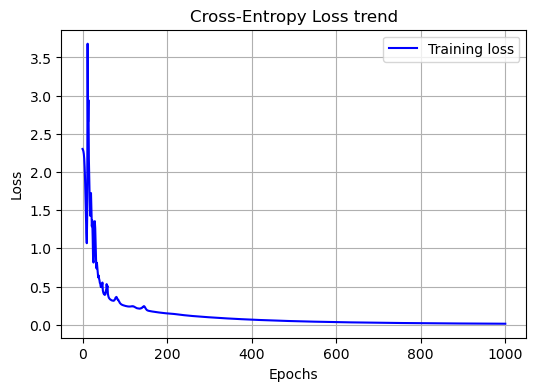

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.plot(losses, label = "Training loss", color = "blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Cross-Entropy Loss trend")
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(X, W1, b1, W2, b2)
    return np.argmax(A2, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

y_test_labels = np.argmax(y_test, axis=1)
y_pred_test = predict(X_test, W1, b1, W2, b2)

acc = accuracy(y_test_labels, y_pred_test)
print(f"Test Accuracy: {acc:.3f}")

Test Accuracy: 0.950


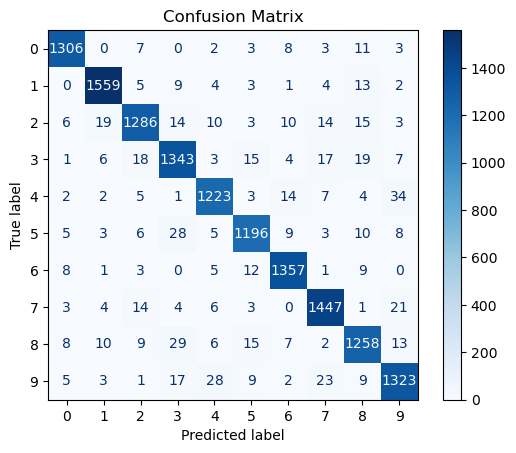

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_labels, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()